<a href="https://colab.research.google.com/github/junghyun9236/TIL/blob/main/langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. yfinanace에서 데이터는 가져오고
2. sqlte에 저장 하고
3. langchain으로 db rag하고 or Tool을 이용해서
4. LLM에 질의하고 결과 찾기 여기까지 하자 .( ~ 6/19)

@ 부가적으로 엘리엇, 일목구름, 컵핸들을 약간씩 변형한 이론을 적용해서 응답을 이끌어 낼 수 있는지도 확인

@ LLM 차이 : Open AI, gemini, LLama 3, ClaudeFlare
@ DB Search or CSV 탐색을 이용했을 때, RAG랑 Tool 차이


In [ ]:
import google.generativeai as genai
GOOGLE_API_KEY=""
genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')
response = model.generate_content("2024년 6월 17일 거래량 TOP 5 코인 목록 알려줘")
print(response.text)

현재 2024년 이전이므로 2024년 6월 17일 거래량 TOP 5 코인 목록을 제공할 수 없습니다.


In [ ]:
import sqlite3

db_path = 'investdb.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

"""
sql = "CREATE TABLE prices(symbol text, date text, open real, high real, low real, close real, volume real)"
cursor.execute(sql)
conn.commit()

sql = "INSERT INTO prices VALUES ('ETH-USD', '2024-01-01',  2282.870361,  2352.327881,  2267.018066,  2352.327881, 6906765990)"
cursor.execute(sql)
"""

sql = "SELECT * FROM prices"
content = cursor.fetchall()
print(content)

[]


In [ ]:
from yahooquery import Ticker

# Google의 티커 심볼 정의
symbol = 'ETH-USD'
samsung = Ticker(symbol)

historical_prices = samsung.history(period='1d', interval='1d', start='2024-01-01', end='2024-06-15', adj_timezone=True, adj_ohlc=False)
print(historical_prices)

                           open         high          low        close  \
symbol  date                                                             
ETH-USD 2024-01-01  2282.870361  2352.327881  2267.018066  2352.327881   
        2024-01-02  2352.593506  2431.212402  2348.892334  2355.836426   
        2024-01-03  2355.981445  2385.117676  2113.925293  2210.761963   
        2024-01-04  2210.529053  2294.608154  2204.865723  2269.038086   
        2024-01-05  2269.409424  2276.764648  2209.537109  2268.647217   
...                         ...          ...          ...          ...   
        2024-06-11  3666.358887  3669.890869  3434.749023  3498.330566   
        2024-06-12  3497.896973  3652.492188  3463.784912  3559.617676   
        2024-06-13  3559.725342  3559.725342  3431.333496  3469.281250   
        2024-06-14  3467.969971  3528.602295  3366.223877  3480.271973   
        2024-06-15  3479.785645  3589.887451  3473.452637  3565.549561   

                         volume     a

In [ ]:
import sqlite3
import os

from yahooquery import Ticker
from yahooquery import Screener

# Symbol 가져오기
def fetch_symbols(limit) :
  s = Screener()
  data = s.get_screeners('all_cryptocurrencies_us', count=limit)
  dicts = data['all_cryptocurrencies_us']['quotes']
  return [d['symbol'] for d in dicts]

# Yahoo Finance에서 주식 가격 데이터 가져오기
def fetch_stock_data(symbols):
  tickers = Ticker(symbols, asynchronous=True)
  df = tickers.history(period='6m', interval='1d', start='2024-01-01', end='2024-06-18', adj_timezone=True, adj_ohlc=False)  # 1년치 데이터를 가져옴
  return df

# SQLite3 데이터베이스에 데이터 삽입
def insert_data_to_sqlite(df, db_path):
  conn = sqlite3.connect(db_path)

  conn.close()

symbols = fetch_symbols(2)
db_path = 'investdb.db'

stock_data = fetch_stock_data(symbols)
insert_data_to_sqlite(stock_data, db_path)


In [ ]:
import sqlite3

conn = sqlite3.connect('invest.db')
cursor = conn.cursor()

sql = "DROP TABLE coin_price"
cursor.execute(sql)

sql = "CREATE TABLE coin_price(name text, date text, open real, high real, low real, close real, volume real, adjclose real)"
cursor.execute(sql)

for idx, row in stock_data.iterrows():
    sql = f"INSERT INTO coin_price VALUES ('{idx[0]}', '{idx[1]}', {row[0]}, {row[1]}, {row[2]}, {row[3]}, {row[4]}, {row[5]})"
    cursor.execute(sql)
    conn.commit()

conn.close()

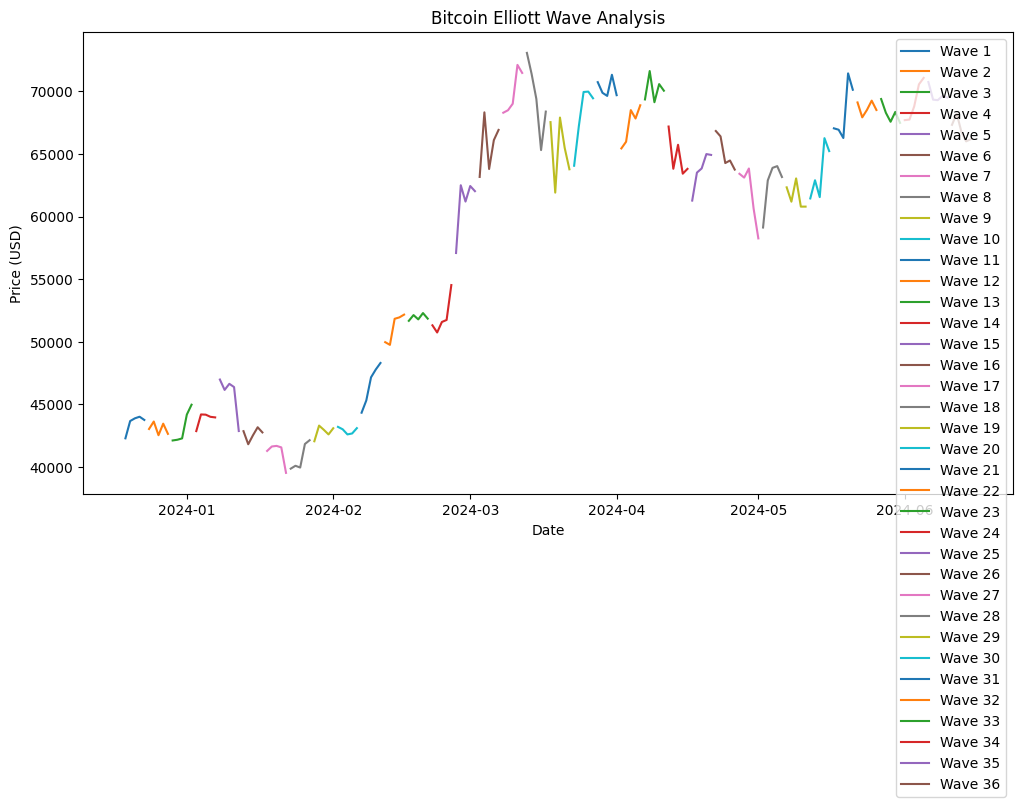

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 비트코인 6개월 일봉 데이터 가져오기
start_date = "2023-12-19"
end_date = "2024-06-19"
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start=start_date, end=end_date, interval="1d")

# 엘리엇 파동 식별을 위한 간단한 로직 구현
# 5개의 하위 파동을 찾고, 교정/충격 파동을 구분
waves = []
wave = []
for i in range(len(btc_data)):
    if len(wave) == 5:
        waves.append(wave)
        wave = []
    wave.append(btc_data.iloc[i])

# 엘리엇 파동 시각화
plt.figure(figsize=(12, 6))
for i, wave in enumerate(waves):
    wave_data = pd.DataFrame(wave)
    plt.plot(wave_data.index, wave_data['Close'], label=f'Wave {i+1}')

plt.title('Bitcoin Elliott Wave Analysis')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
import sqlite3

conn = sqlite3.connect('invest.db')
cursor = conn.cursor()

cursor.execute("select * from coin_price")
rows = cursor.fetchall()

for row in rows:
  print(row)

conn.close()


('BTC-USD', '2024-01-01', 42280.234375, 44175.4375, 42214.9765625, 44167.33203125, 18426978443.0, 44167.33203125)
('BTC-USD', '2024-01-02', 44187.140625, 45899.70703125, 44176.94921875, 44957.96875, 39335274536.0, 44957.96875)
('BTC-USD', '2024-01-03', 44961.6015625, 45503.2421875, 40813.53515625, 42848.17578125, 46342323118.0, 42848.17578125)
('BTC-USD', '2024-01-04', 42855.81640625, 44770.0234375, 42675.17578125, 44179.921875, 30448091210.0, 44179.921875)
('BTC-USD', '2024-01-05', 44192.98046875, 44353.28515625, 42784.71875, 44162.69140625, 32336029347.0, 44162.69140625)
('BTC-USD', '2024-01-06', 44178.953125, 44227.6328125, 43475.15625, 43989.1953125, 16092503468.0, 43989.1953125)
('BTC-USD', '2024-01-07', 43998.46484375, 44495.5703125, 43662.23046875, 43943.09765625, 19330573863.0, 43943.09765625)
('BTC-USD', '2024-01-08', 43948.70703125, 47218.0, 43244.08203125, 46970.50390625, 42746192015.0, 46970.50390625)
('BTC-USD', '2024-01-09', 46987.640625, 47893.69921875, 45244.71484375, 4

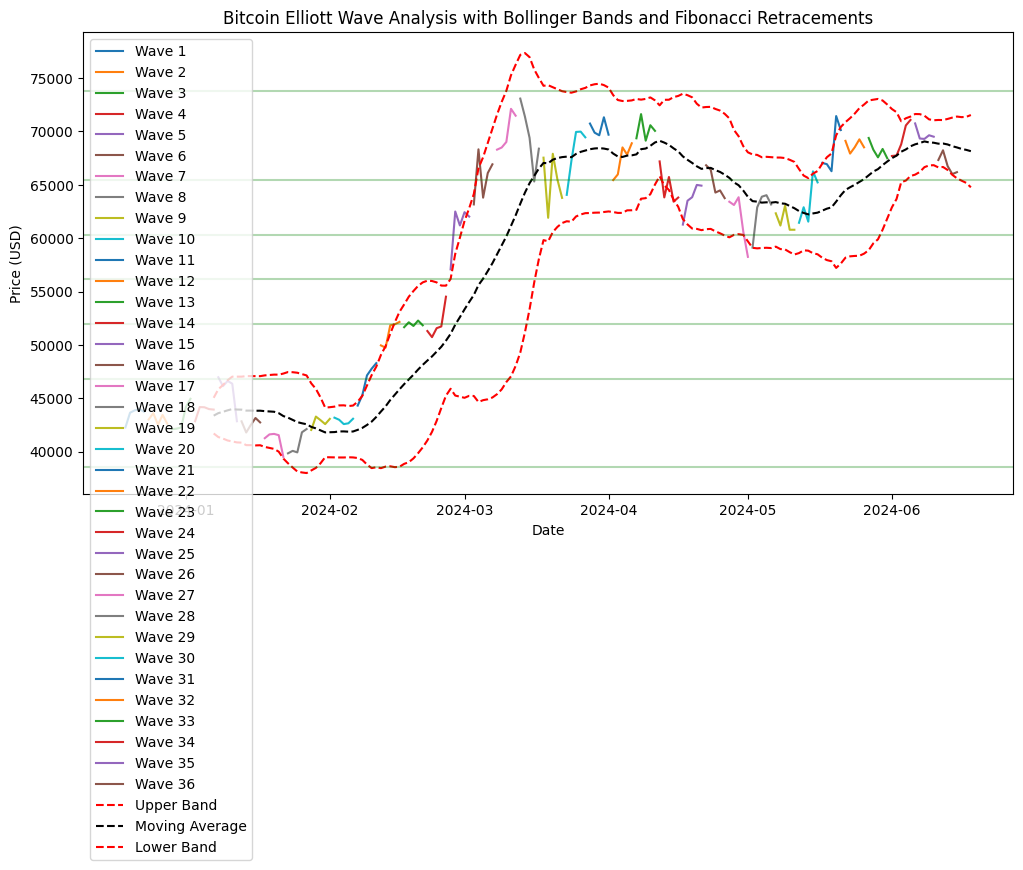

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 비트코인 6개월 일봉 데이터 가져오기
start_date = "2023-12-19"
end_date = "2024-06-19"
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start=start_date, end=end_date, interval="1d")

# 엘리엇 파동 식별을 위한 간단한 로직 구현
# 5개의 하위 파동을 찾고, 교정/충격 파동을 구분
waves = []
wave = []
for i in range(len(btc_data)):
   if len(wave) == 5:
       waves.append(wave)
       wave = []
   wave.append(btc_data.iloc[i])

# 볼린저 밴드 계산
n = 20  # 볼린저 밴드 기간
btc_data['MA'] = btc_data['Close'].rolling(n).mean()
btc_data['STDDEV'] = btc_data['Close'].rolling(n).std()
btc_data['UPPER'] = btc_data['MA'] + (2 * btc_data['STDDEV'])
btc_data['LOWER'] = btc_data['MA'] - (2 * btc_data['STDDEV'])

# 피보나치 수열 계산
fib_levels = [0, 23.6, 38.2, 50, 61.8, 76.4, 100]
high = btc_data['High'].max()
low = btc_data['Low'].min()
fib_retracements = [low + (high - low) * (level / 100) for level in fib_levels]

# 엘리엇 파동 시각화
plt.figure(figsize=(12, 6))
for i, wave in enumerate(waves):
   wave_data = pd.DataFrame(wave)
   plt.plot(wave_data.index, wave_data['Close'], label=f'Wave {i+1}')

# 볼린저 밴드 시각화
plt.plot(btc_data.index, btc_data['UPPER'], 'r--', label='Upper Band')
plt.plot(btc_data.index, btc_data['MA'], 'k--', label='Moving Average')
plt.plot(btc_data.index, btc_data['LOWER'], 'r--', label='Lower Band')

# 피보나치 수열 시각화
for level in fib_retracements:
   plt.axhline(y=level, color='g', linestyle='-', alpha=0.3)

plt.title('Bitcoin Elliott Wave Analysis with Bollinger Bands and Fibonacci Retracements')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


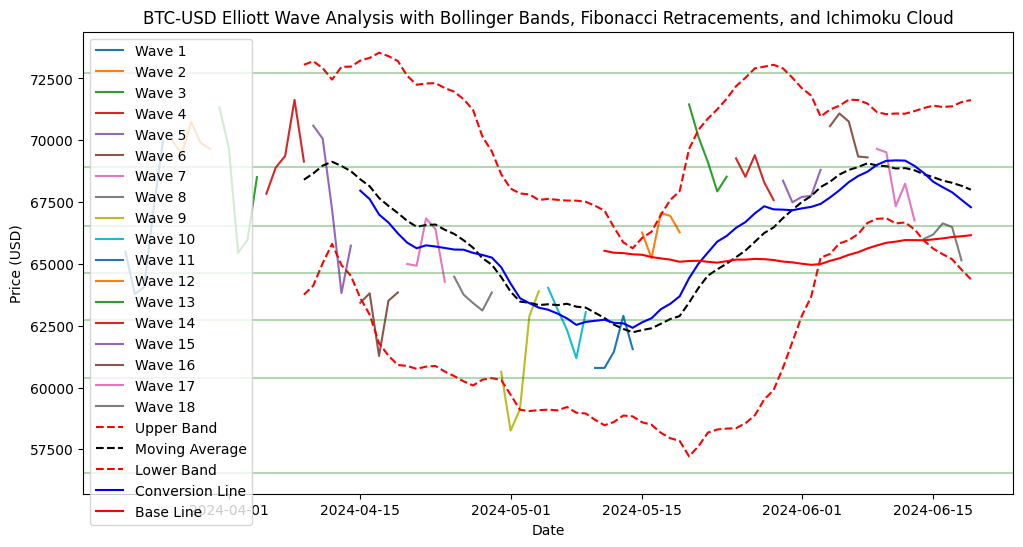

[*********************100%%**********************]  1 of 1 completed


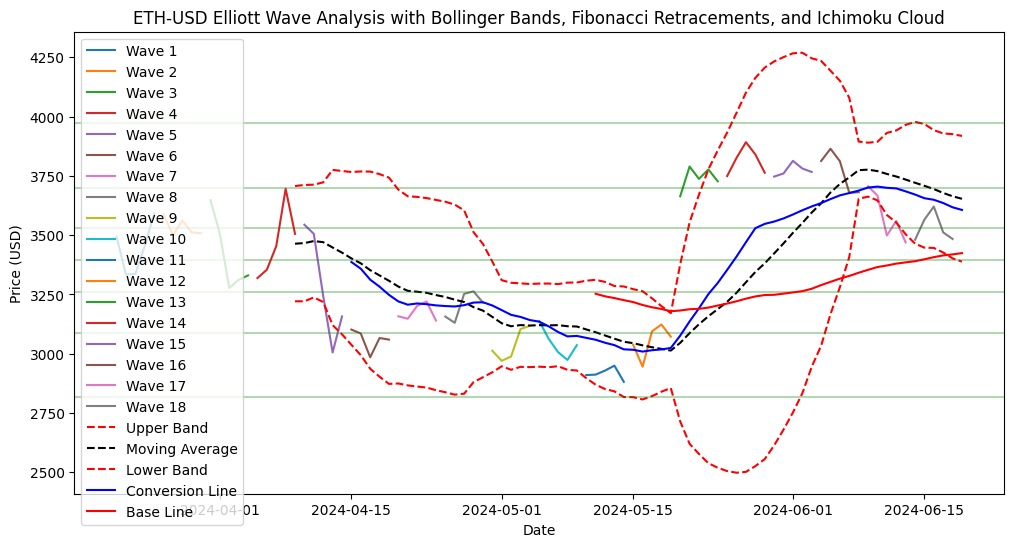

[*********************100%%**********************]  1 of 1 completed


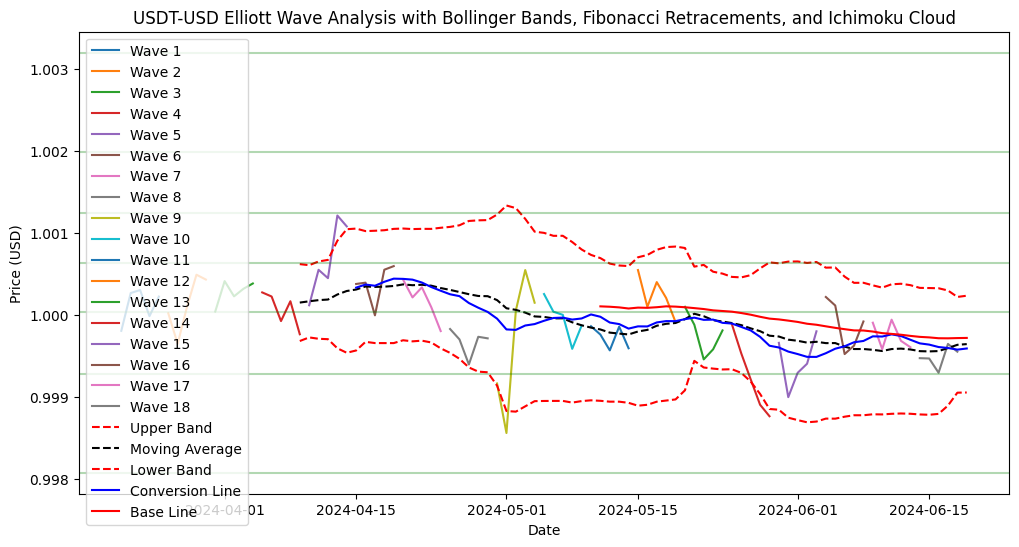

[*********************100%%**********************]  1 of 1 completed


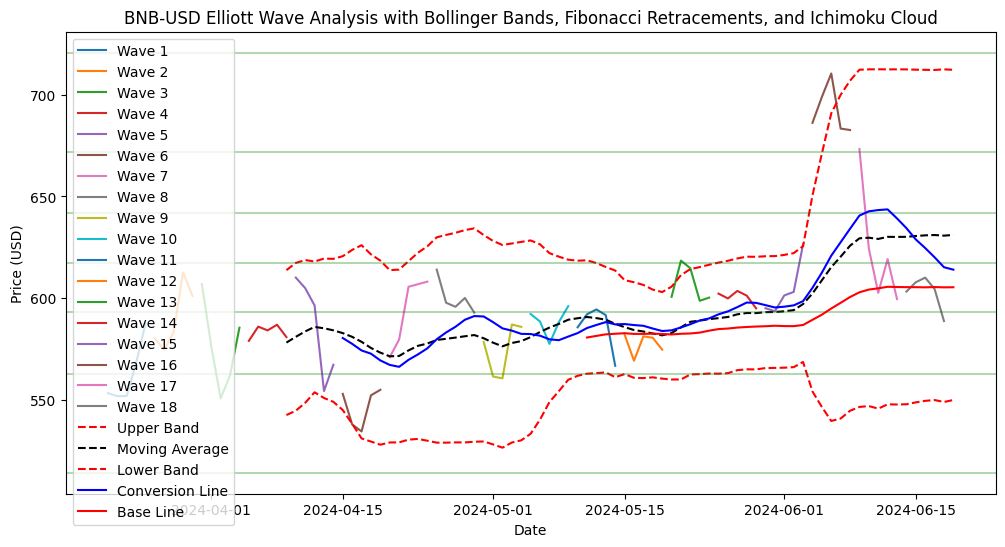

[*********************100%%**********************]  1 of 1 completed


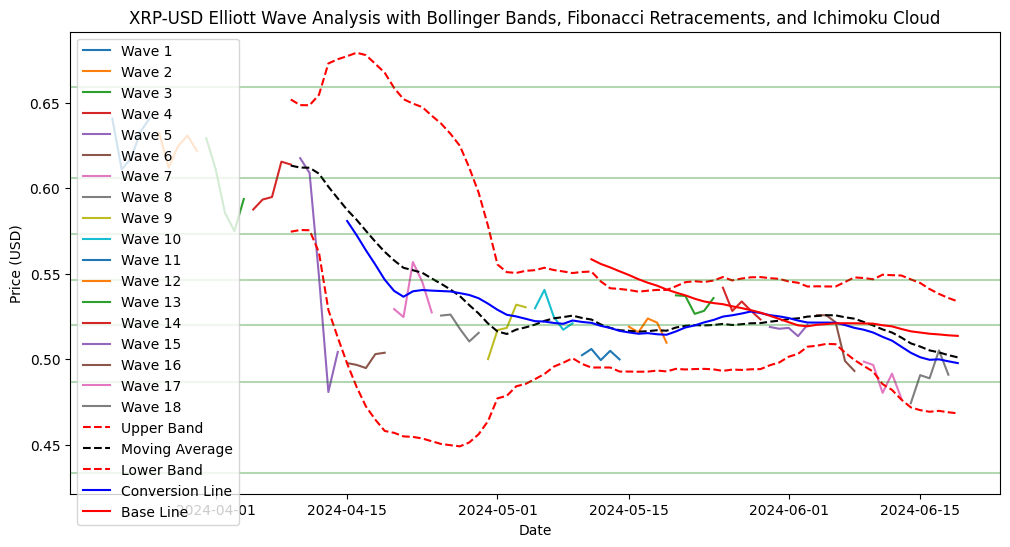

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 상위 5개 코인 티커 설정
tickers = ["BTC-USD", "ETH-USD", "USDT-USD", "BNB-USD", "XRP-USD"]

# 3개월 전 날짜 계산
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=90)

for ticker in tickers:
    try:
        # 코인 데이터 가져오기
        coin_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

        # 엘리엇 파동 식별 및 시각화
        waves = []
        wave = []
        for i in range(len(coin_data)):
            if len(wave) == 5:
                waves.append(wave)
                wave = []
            wave.append(coin_data.iloc[i])

        plt.figure(figsize=(12, 6))
        for i, wave in enumerate(waves):
            wave_df = pd.DataFrame(wave)
            plt.plot(wave_df.index, wave_df['Close'], label=f'Wave {i+1}')

        # 볼린저 밴드 계산 및 시각화
        n = 20
        coin_data['MA'] = coin_data['Close'].rolling(n).mean()
        coin_data['STDDEV'] = coin_data['Close'].rolling(n).std()
        coin_data['UPPER'] = coin_data['MA'] + (2 * coin_data['STDDEV'])
        coin_data['LOWER'] = coin_data['MA'] - (2 * coin_data['STDDEV'])

        plt.plot(coin_data.index, coin_data['UPPER'], 'r--', label='Upper Band')
        plt.plot(coin_data.index, coin_data['MA'], 'k--', label='Moving Average')
        plt.plot(coin_data.index, coin_data['LOWER'], 'r--', label='Lower Band')

        # 피보나치 수열 계산 및 시각화
        fib_levels = [0, 23.6, 38.2, 50, 61.8, 76.4, 100]
        high = coin_data['High'].max()
        low = coin_data['Low'].min()
        fib_retracements = [low + (high - low) * (level / 100) for level in fib_levels]

        for level in fib_retracements:
            plt.axhline(y=level, color='g', linestyle='-', alpha=0.3)

        # 일목구름 계산 및 시각화
        n1 = 9
        n2 = 26
        n3 = 52
        coin_data['Conv_Line'] = (coin_data['Close'].rolling(n1).mean() + coin_data['Close'].rolling(n2).mean()) / 2
        coin_data['Base_Line'] = coin_data['Close'].rolling(n3).mean()
        coin_data['Lead_Span_1'] = ((coin_data['Conv_Line'] + coin_data['Base_Line']) / 2).shift(n2)
        coin_data['Lead_Span_2'] = ((coin_data['Conv_Line'].shift(n2) + coin_data['Base_Line'].shift(n2)) / 2).shift(n2)

        plt.plot(coin_data.index, coin_data['Conv_Line'], 'b-', label='Conversion Line')
        plt.plot(coin_data.index, coin_data['Base_Line'], 'r-', label='Base Line')
        plt.fill_between(coin_data.index, coin_data['Lead_Span_1'], coin_data['Lead_Span_2'], where=coin_data['Lead_Span_1'] >= coin_data['Lead_Span_2'], color='green', alpha=0.3)
        plt.fill_between(coin_data.index, coin_data['Lead_Span_1'], coin_data['Lead_Span_2'], where=coin_data['Lead_Span_1'] < coin_data['Lead_Span_2'], color='red', alpha=0.3)

        plt.title(f'{ticker} Elliott Wave Analysis with Bollinger Bands, Fibonacci Retracements, and Ichimoku Cloud')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

from yahooquery import Ticker
from yahooquery import Screener

# 상위 5개 코인 티커 설정
s = Screener()
data = s.get_screeners('all_cryptocurrencies_us', count=20)
dicts = data['all_cryptocurrencies_us']['quotes']
tickers = [d['symbol'] for d in dicts]

# 3개월 전 날짜 계산
end_date = pd.Timestamp.today()
start_date = end_date - pd.Timedelta(days=90)

def is_uptrend(data):
    # 엘리엇 파동 분석
    waves = []
    wave = []
    for i in range(len(data)):
        if len(wave) == 5:
            waves.append(wave)
            wave = []
        wave.append(data.iloc[i])
    # 최근 파동이 상승 추세인지 확인
    if waves and all(wave[3].iloc[-1] > wave[3].iloc[0] for wave in waves[-3:]):
        uptrend_wave = True
    else:
        uptrend_wave = False

    # 볼린저 밴드
    n = 20
    data['MA'] = data['Close'].rolling(n).mean()
    data['STDDEV'] = data['Close'].rolling(n).std()
    data['UPPER'] = data['MA'] + (2 * data['STDDEV'])
    data['LOWER'] = data['MA'] - (2 * data['STDDEV'])

    # 최근 가격이 상단 밴드 위에 있는지 확인
    uptrend_bbands = data['Close'].iloc[-1] > data['UPPER'].iloc[-1]
    # 피보나치 수열
    high = data['High'].max()
    low = data['Low'].min()
    fib_levels = [low + (high - low) * (level / 100) for level in [23.6, 38.2, 50, 61.8]]

    # 최근 가격이 피보나치 수준을 돌파했는지 확인
    uptrend_fib = data['Close'].iloc[-1] > max(fib_levels)

    # 일목구름
    n1, n2, n3 = 9, 26, 52
    data['Conv_Line'] = (data['Close'].rolling(n1).mean() + data['Close'].rolling(n2).mean()) / 2
    data['Base_Line'] = data['Close'].rolling(n3).mean()
    data['Lead_Span_1'] = ((data['Conv_Line'] + data['Base_Line']) / 2).shift(n2)
    data['Lead_Span_2'] = ((data['Conv_Line'].shift(n2) + data['Base_Line'].shift(n2)) / 2).shift(n2)

    # 전환선이 기준선 위에 있고, 가격이 구름 위에 있는지 확인
    uptrend_ichimoku = (data['Conv_Line'].iloc[-1] > data['Base_Line'].iloc[-1]) and (data['Close'].iloc[-1] > data['Lead_Span_2'].iloc[-1])

    print(f"엘리엇파동 : {uptrend_wave},  볼린저밴드 : {uptrend_bbands}, 피보나치 : {uptrend_fib}, 일목구름 : {uptrend_ichimoku}")
    return uptrend_wave and uptrend_bbands and uptrend_fib and uptrend_ichimoku

for ticker in tickers:
    try:
        # 코인 데이터 가져오기
        coin_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

        # 상승 추세 판단
        if is_uptrend(coin_data):
            print(f"{ticker} is currently in an uptrend.")
        else:
            print(f"{ticker} is not currently in an uptrend.")

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
BTC-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : True, 일목구름 : False
ETH-USD is not currently in an uptrend.



[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
USDT-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
BNB-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
SOL-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : True, 일목구름 : False
STETH-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
USDC-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
XRP-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
DOGE-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : True, 일목구름 : False
TON11419-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
ADA-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : True, 일목구름 : False
WSTETH-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : True, 일목구름 : False
WETH-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
SHIB-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
AVAX-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
WTRX-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
TRX-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
WBTC-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
DOT-USD is not currently in an uptrend.
엘리엇파동 : True,  볼린저밴드 : False, 피보나치 : False, 일목구름 : False
LINK-USD is not currently in an uptrend.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


005930.KS data saved to 005930.KS.csv
000660.KS data saved to 000660.KS.csv
207940.KS data saved to 207940.KS.csv
035420.KS data saved to 035420.KS.csv
051910.KS data saved to 051910.KS.csv
005490.KS data saved to 005490.KS.csv
006400.KS data saved to 006400.KS.csv
003550.KS data saved to 003550.KS.csv
035720.KS data saved to 035720.KS.csv
068270.KS data saved to 068270.KS.csv
005930.KS 매수 타이밍:
Series([], Name: Close, dtype: float64)

005930.KS 매도 타이밍:
Series([], Name: Close, dtype: float64)
------------------------------


ValueError: operands could not be broadcast together with shapes (59,) (0,) 

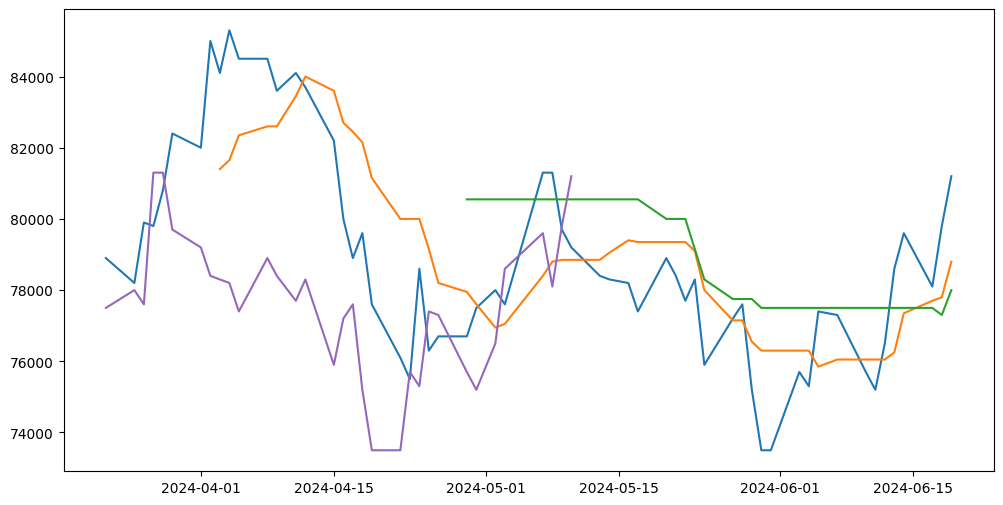

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 야후 파이낸스에서 지원하는 국내 상장 종목 코드 리스트
kr_tickers = ["005930.KS", "000660.KS", "207940.KS", "035420.KS", "051910.KS", "005490.KS", "006400.KS", "003550.KS", "035720.KS", "068270.KS"]

# 최근 3개월 기간 설정
today = datetime.now()
start_date = today - timedelta(days=90)

# 거래량 높은 10개 주식 일봉 데이터 가져오기
stock_data = {}
for ticker in kr_tickers:
    try:
        data = yf.download(ticker, start=start_date, end=today, interval="1d")
        if not data.empty:
            stock_data[ticker] = data
    except:
        print(f"Error fetching data for {ticker}")

# 일봉 데이터 저장
for ticker, data in stock_data.items():
    data.to_csv(f"{ticker}.csv")
    print(f"{ticker} data saved to {ticker}.csv")

# 일목구름표 계산 함수
def ichimoku_cloud(data, n1=9, n2=26, n3=52):
    high = data['High']
    low = data['Low']
    close = data['Close']

    # 전환선 (Conversion Line)
    conv_line = (high.rolling(n1).max() + low.rolling(n1).min()) / 2

    # 기준선 (Base Line)
    base_line = (high.rolling(n2).max() + low.rolling(n2).min()) / 2

    # 선행스팬 (Leading Span)
    lead_span_a = (conv_line + base_line) / 2
    lead_span_b = ((high.rolling(n3).max() + low.rolling(n3).min()) / 2).shift(n3)
    lead_span = pd.Series(lead_span_b.values, index=lead_span_a.index)

    # 지연스팬 (Lagging Span)
    #lag_span = close.rolling(n2).shift(-n2)
    lag_span = close.shift(-n2)

    # 구름 (Cloud)
    cloud_green = lead_span >= lead_span_b
    cloud_red = lead_span < lead_span_b

    return conv_line, base_line, lead_span, lag_span, cloud_green, cloud_red

# 매수/매도 타이밍 판단 함수
def trade_signal(data):
    conv_line, base_line, lead_span, lag_span, cloud_green, cloud_red = ichimoku_cloud(data)

    # 매수 신호: 전환선이 기준선을 상향 돌파하고, 가격이 구름 밖에 있을 때
    buy_signal = (conv_line.shift(1) < base_line.shift(1)) & (conv_line > base_line) & cloud_green

    # 매도 신호: 전환선이 기준선을 하향 돌파하고, 가격이 구름 안에 있을 때
    sell_signal = (conv_line.shift(1) > base_line.shift(1)) & (conv_line < base_line) & cloud_red

    return buy_signal, sell_signal

# 그래프 출력 함수
def plot_ichimoku(data, buy_signal, sell_signal):
    conv_line, base_line, lead_span, lag_span, cloud_green, cloud_red = ichimoku_cloud(data)

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close')
    plt.plot(conv_line.index, conv_line, label='Conversion Line')
    plt.plot(base_line.index, base_line, label='Base Line')
    plt.plot(lead_span.index, lead_span, label='Leading Span')
    plt.plot(lag_span.index, lag_span, label='Lagging Span')
    plt.fill_between(cloud_green.index, lead_span[cloud_green], lag_span[cloud_green], color='green', alpha=0.3, label='Cloud Green')
    plt.fill_between(cloud_red.index, lead_span[cloud_red], lag_span[cloud_red], color='red', alpha=0.3, label='Cloud Red')
    plt.scatter(data.index[buy_signal], data['Close'][buy_signal], marker='^', color='g', label='Buy Signal', s=100)
    plt.scatter(data.index[sell_signal], data['Close'][sell_signal], marker='v', color='r', label='Sell Signal', s=100)
    plt.legend()
    plt.title(f"{data.name} Ichimoku Cloud")
    plt.show()

# 매수/매도 타이밍 계산 및 그래프 출력
for ticker, data in stock_data.items():
    data = pd.read_csv(f"{ticker}.csv", index_col='Date', parse_dates=True)
    buy, sell = trade_signal(data)

    print(f"{ticker} 매수 타이밍:")
    print(data.loc[buy.values, 'Close'])
    print(f"\n{ticker} 매도 타이밍:")
    print(data.loc[sell.values, 'Close'])
    print("-" * 30)

    plot_ichimoku(data, buy, sell)

ValueError: too many values to unpack (expected 2)